In [1]:
!pip install xrft==0.3.0
!pip install numpy_groupies

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37485")
client

Client Scheduler: tcp://127.0.0.1:37485 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 64 Memory: 270.48 GB


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar
import xrft
import gsw
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [34]:
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [4]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

url = "s3://Pangeo/pangeo-forge/swot_adac/eNATL60/"
enatl60_datasets = {
    ds: xr.open_zarr(fs_osn.get_mapper(f"{url}{ds}.zarr"), consolidated=True)
    for ds in ["Region03/surface_hourly/fma","Region03/surface_hourly/aso"]
}
enatl60_datasets

{'Region03/surface_hourly/fma': <xarray.Dataset>
 Dimensions:        (time_counter: 2136, x: 574, y: 675)
 Coordinates:
     depth          (y, x) float32 dask.array<chunksize=(675, 574), meta=np.ndarray>
     e1f            (y, x) float64 dask.array<chunksize=(675, 574), meta=np.ndarray>
     e1t            (y, x) float64 dask.array<chunksize=(675, 574), meta=np.ndarray>
     e1u            (y, x) float64 dask.array<chunksize=(675, 574), meta=np.ndarray>
     e1v            (y, x) float64 dask.array<chunksize=(675, 574), meta=np.ndarray>
     e2f            (y, x) float64 dask.array<chunksize=(675, 574), meta=np.ndarray>
     e2t            (y, x) float64 dask.array<chunksize=(675, 574), meta=np.ndarray>
     e2u            (y, x) float64 dask.array<chunksize=(675, 574), meta=np.ndarray>
     e2v            (y, x) float64 dask.array<chunksize=(675, 574), meta=np.ndarray>
     lat            (y, x) float32 dask.array<chunksize=(675, 574), meta=np.ndarray>
     lon            (y, x) flo

In [5]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

url = "s3://Pangeo/pangeo-forge/swot_adac/HYCOM50/"
hycom50_datasets = {
    ds: xr.open_zarr(fs_osn.get_mapper(f"{url}{ds}.zarr"), consolidated=True, decode_times=False)
    for ds in ["Region03_MD/surf/fma","Region03_MD/surf/aso"]
}
hycom50_datasets

{'Region03_MD/surf/fma': <xarray.Dataset>
 Dimensions:    (lat: 522, lon: 503, time: 2160)
 Coordinates:
   * time       (time) int64 0 1 2 3 4 5 6 ... 2153 2154 2155 2156 2157 2158 2159
 Dimensions without coordinates: lat, lon
 Data variables:
     latitude   (lat) float32 dask.array<chunksize=(522,), meta=np.ndarray>
     longitude  (lon) float32 dask.array<chunksize=(503,), meta=np.ndarray>
     ssh        (time, lat, lon) float32 dask.array<chunksize=(24, 522, 503), meta=np.ndarray>
     sss        (time, lat, lon) float32 dask.array<chunksize=(24, 522, 503), meta=np.ndarray>
     sst        (time, lat, lon) float32 dask.array<chunksize=(24, 522, 503), meta=np.ndarray>
     tauewd     (time, lat, lon) float32 dask.array<chunksize=(24, 522, 503), meta=np.ndarray>
     taunwd     (time, lat, lon) float32 dask.array<chunksize=(24, 522, 503), meta=np.ndarray>
     uu1        (time, lat, lon) float32 dask.array<chunksize=(24, 522, 503), meta=np.ndarray>
     vv1        (time, lat, lon)

In [6]:
winter = np.concatenate((np.concatenate((np.repeat(2,696),
                                         np.repeat(3,744))),
                         np.repeat(4,720)))
summer = np.concatenate((np.concatenate((np.repeat(8,744),
                                         np.repeat(9,720))),
                         np.repeat(10,744)))
summer

array([ 8,  8,  8, ..., 10, 10, 10])

In [7]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

url = "s3://Pangeo/pangeo-forge/swot_adac/HYCOM50/"
hycom50_grids = {
    grid: xr.open_zarr(fs_osn.get_mapper(f"{url}{grid}.zarr"), consolidated=True)
    for grid in ["grid_03"]
}

hycom50_grids

{'grid_03': <xarray.Dataset>
 Dimensions:    (lat: 522, lon: 503)
 Dimensions without coordinates: lat, lon
 Data variables:
     depth      (lat, lon) float64 dask.array<chunksize=(522, 503), meta=np.ndarray>
     latitude   (lat) float64 dask.array<chunksize=(522,), meta=np.ndarray>
     longitude  (lon) float64 dask.array<chunksize=(503,), meta=np.ndarray>}

In [8]:
from xmitgcm import llcreader
model = llcreader.ECCOPortalLLC2160Model()
print(model.varnames)

['Eta', 'KPPhbl', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux', 'oceTAUX', 'oceTAUY', 'PhiBot', 'Salt', 'SIarea', 'SIheff', 'SIhsalt', 'SIhsnow', 'SIuice', 'SIvice', 'Theta', 'U', 'V', 'W']


In [9]:
llc03w = model.get_dataset(varnames=['U','V','Eta'], k_levels=[0], 
                           type='latlon').sel(time=slice('2012-02-01','2012-04-30'),
                                              j=slice(4943,5225),j_g=slice(4943,5225),
                                              i=slice(862,1105),i_g=slice(862,1105),
                                              k=0)
llc03w

<xarray.Dataset>
Dimensions:  (face: 13, i: 244, i_g: 244, j: 283, j_g: 283, k_l: 1, k_p1: 2, k_u: 1, time: 2160)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 862 863 864 865 866 867 ... 1100 1101 1102 1103 1104 1105
  * i_g      (i_g) int64 862 863 864 865 866 867 ... 1101 1102 1103 1104 1105
  * j        (j) int64 4943 4944 4945 4946 4947 ... 5221 5222 5223 5224 5225
  * j_g      (j_g) int64 4943 4944 4945 4946 4947 ... 5221 5222 5223 5224 5225
    k        int64 0
  * k_u      (k_u) int64 0
  * k_l      (k_l) int64 0
  * k_p1     (k_p1) int64 0 1
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-04-30T23:00:00
    CS       (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    drC      (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      >f4 dask.array<chunksize=(), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    dxF      (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    dyF      (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    hFacC    (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    hFacS    (j_g, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    hFacW    (j, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    PHrefC   >f4 dask.array<chunksize=(), meta=np.ndarray>
    PHrefF   (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    Z        >f4 dask.array<chunksize=(), meta=np.ndarray>
    Zp1      (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    rhoRef   >f4 dask.array<chunksize=(), meta=np.ndarray>
    rLowC    (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rLowS    (j_g, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rLowW    (j, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rSurfC   (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rSurfS   (j_g, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rSurfW   (j, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    dxV      (j_g, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    dyU      (j_g, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    Zl       (k_l) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    Zu       (k_u) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 283, 244), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 283, 244), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 283, 244), meta=np.ndarray>

In [10]:
llc03s = model.get_dataset(varnames=['U','V','Eta'], k_levels=[0], 
                           type='latlon').sel(time=slice('2011-08-01','2011-10-31'),
                                              j=slice(4943,5225),j_g=slice(4943,5225),
                                              i=slice(862,1105),i_g=slice(862,1105),
                                              k=0)
llc03s

<xarray.Dataset>
Dimensions:  (face: 13, i: 244, i_g: 244, j: 283, j_g: 283, k_l: 1, k_p1: 2, k_u: 1, time: 2208)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 862 863 864 865 866 867 ... 1100 1101 1102 1103 1104 1105
  * i_g      (i_g) int64 862 863 864 865 866 867 ... 1101 1102 1103 1104 1105
  * j        (j) int64 4943 4944 4945 4946 4947 ... 5221 5222 5223 5224 5225
  * j_g      (j_g) int64 4943 4944 4945 4946 4947 ... 5221 5222 5223 5224 5225
    k        int64 0
  * k_u      (k_u) int64 0
  * k_l      (k_l) int64 0
  * k_p1     (k_p1) int64 0 1
  * time     (time) datetime64[ns] 2011-08-01 ... 2011-10-31T23:00:00
    CS       (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    drC      (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      >f4 dask.array<chunksize=(), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    dxF      (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    dyF      (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    hFacC    (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    hFacS    (j_g, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    hFacW    (j, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    PHrefC   >f4 dask.array<chunksize=(), meta=np.ndarray>
    PHrefF   (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    Z        >f4 dask.array<chunksize=(), meta=np.ndarray>
    Zp1      (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    rhoRef   >f4 dask.array<chunksize=(), meta=np.ndarray>
    rLowC    (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rLowS    (j_g, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rLowW    (j, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rSurfC   (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rSurfS   (j_g, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rSurfW   (j, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    dxV      (j_g, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    dyU      (j_g, i_g) float32 dask.array<chunksize=(283, 244), meta=np.ndarray>
    Zl       (k_l) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    Zu       (k_u) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 283, 244), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 283, 244), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 283, 244), meta=np.ndarray>

In [15]:
enatl03s = enatl60_datasets["Region03/surface_hourly/aso"]
Ny = len(enatl03s.y)
Nx = len(enatl03s.x)
dx = enatl03s.e1t.mean(skipna=True)
dy = enatl03s.e2t.mean(skipna=True)

if 1/(2*dx) > 1/(2*dy):
    Kenatl = 1/(2*dy)
else:
    Kenatl = 1/(2*dx)
enatl03s_H = xr.DataArray(enatl03s.sossheig.data, dims=['time','YC','XC'],
                          coords={'time':np.arange(len(enatl02s.time_counter))*3600,
                                  'YC':np.arange(0,Ny*dy,dy),
                                  'XC':np.arange(0,Nx*dx,dx)}
                         ).chunk({'time':1})
enatl03s_H

<xarray.DataArray 'xarray-sossheig-c1e4861857eb3f5d9fead5288880cf4a' (time: 1464, YC: 675, XC: 574)>
dask.array<rechunk-merge, shape=(1464, 675, 574), dtype=float32, chunksize=(1, 675, 574), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 5256000 5259600 5263200 5266800
  * YC       (YC) float64 0.0 1.369e+03 2.739e+03 ... 9.216e+05 9.23e+05
  * XC       (XC) float64 0.0 1.433e+03 2.867e+03 ... 8.199e+05 8.214e+05

In [16]:
enatl03w = enatl60_datasets["Region03/surface_hourly/fma"]
Ny = len(enatl03w.y)
Nx = len(enatl03w.x)
dx = enatl03w.e1t.mean(skipna=True)
dy = enatl03w.e2t.mean(skipna=True)

if 1/(2*dx) > 1/(2*dy):
    Kenatl = 1/(2*dy)
else:
    Kenatl = 1/(2*dx)
enatl03w_H = xr.DataArray(enatl03w.sossheig.data, dims=['time','YC','XC'],
                          coords={'time':np.arange(len(enatl02w.time_counter))*3600,
                                  'YC':np.arange(0,Ny*dy,dy),
                                  'XC':np.arange(0,Nx*dx,dx)}
                         ).chunk({'time':1})
enatl03w_H

<xarray.DataArray 'xarray-sossheig-05776ab19864e89aeb13922c6b30ef09' (time: 2136, YC: 675, XC: 574)>
dask.array<rechunk-merge, shape=(2136, 675, 574), dtype=float32, chunksize=(1, 675, 574), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7675200 7678800 7682400 7686000
  * YC       (YC) float64 0.0 1.369e+03 2.739e+03 ... 9.216e+05 9.23e+05
  * XC       (XC) float64 0.0 1.433e+03 2.867e+03 ... 8.199e+05 8.214e+05

Text(0, 0.5, '[km]')

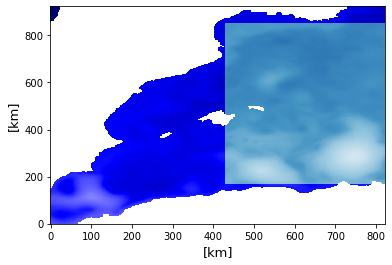

In [57]:
fig, ax = plt.subplots()
ax.pcolormesh(enatl03w_H.isel(time=0).XC*1e-3, enatl03w_H.isel(time=0).YC*1e-3,
              enatl03w_H.isel(time=0), cmap='seismic', vmax=1, vmin=-1)
ax.pcolormesh(enatl03w_H.isel(time=0).sel(YC=slice(1.7e5,8.5e5),XC=slice(4.3e5,None)).XC*1e-3,
              enatl03w_H.isel(time=0).sel(YC=slice(1.7e5,8.5e5),XC=slice(4.3e5,None)).YC*1e-3,
              enatl03w_H.isel(time=0).sel(YC=slice(1.7e5,8.5e5),XC=slice(4.3e5,None)), 
              cmap='RdBu_r', vmax=1, vmin=-1)
ax.set_xlabel("[km]", fontsize=13)
ax.set_ylabel("[km]", fontsize=13)

In [23]:
hycom03w = hycom50_datasets["Region03_MD/surf/fma"]
Ny = len(hycom50_grids["grid_03"].lat)
Nx = len(hycom50_grids["grid_03"].lon)
import gsw
xx, yy = np.meshgrid(hycom50_grids["grid_03"].longitude, hycom50_grids["grid_03"].latitude)
dx = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                  coords={'lat':np.arange(522),'lon':np.arange(.5,502,1)}
                 ).interp(lon=np.arange(503), method="linear",
                          kwargs={"fill_value": "extrapolate"}).mean()
dy = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                  coords={'lat':np.arange(.5,521,1),'lon':np.arange(503)}
                 ).interp(lat=np.arange(522), method="linear",
                          kwargs={"fill_value": "extrapolate"}).mean()
if 1/(2*dx) > 1/(2*dy):
    Khycom = 1/(2*dy)
else:
    Khycom = 1/(2*dx)
hycom03w_H = xr.DataArray(hycom03w.ssh.data*1e-2, dims=['time','YC','XC'],
                          coords={'time':np.arange(len(hycom03w.time))*3600,
                                  'YC':np.arange(0,Ny*dy,dy),
                                  'XC':np.arange(0,Nx*dx,dx),
#                                   'month':('time',winter)
                                 }
                         ).chunk({'time':1})

hycom03w_H

<xarray.DataArray 'mul-ec24f769a93c2deb8f81f30c016320a9' (time: 2160, YC: 522, XC: 503)>
dask.array<rechunk-merge, shape=(2160, 522, 503), dtype=float32, chunksize=(1, 522, 503), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7761600 7765200 7768800 7772400
  * YC       (YC) float64 0.0 1.713e+03 3.425e+03 ... 8.906e+05 8.923e+05
  * XC       (XC) float64 0.0 1.713e+03 3.425e+03 ... 8.581e+05 8.598e+05

In [26]:
hycom03s = hycom50_datasets["Region03_MD/surf/aso"]
Ny = len(hycom50_grids["grid_03"].lat)
Nx = len(hycom50_grids["grid_03"].lon)
import gsw
xx, yy = np.meshgrid(hycom50_grids["grid_03"].longitude, hycom50_grids["grid_03"].latitude)
dx = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                  coords={'lat':np.arange(522),'lon':np.arange(.5,502,1)}
                 ).interp(lon=np.arange(503), method="linear",
                          kwargs={"fill_value": "extrapolate"}).mean()
dy = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                  coords={'lat':np.arange(.5,521,1),'lon':np.arange(503)}
                 ).interp(lat=np.arange(522), method="linear",
                          kwargs={"fill_value": "extrapolate"}).mean()
if 1/(2*dx) > 1/(2*dy):
    Khycom = 1/(2*dy)
else:
    Khycom = 1/(2*dx)
hycom03s_H = xr.DataArray(hycom03s.ssh.data*1e-2, dims=['time','YC','XC'],
                          coords={'time':np.arange(len(hycom03s.time))*3600,
                                  'YC':np.arange(0,Ny*dy,dy),
                                  'XC':np.arange(0,Nx*dx,dx),
#                                   'month':('time',winter)
                                 }
                         ).chunk({'time':1})

hycom03s_H

<xarray.DataArray 'mul-6e44bea3c1cc434e0129c0f4da71fb5b' (time: 2208, YC: 522, XC: 503)>
dask.array<rechunk-merge, shape=(2208, 522, 503), dtype=float32, chunksize=(1, 522, 503), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7934400 7938000 7941600 7945200
  * YC       (YC) float64 0.0 1.713e+03 3.425e+03 ... 8.906e+05 8.923e+05
  * XC       (XC) float64 0.0 1.713e+03 3.425e+03 ... 8.581e+05 8.598e+05

Text(0, 0.5, '[km]')

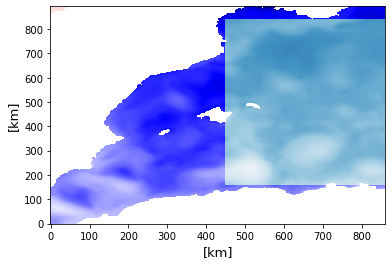

In [52]:
fig, ax = plt.subplots()
ax.pcolormesh(hycom03w_H.isel(time=0).XC*1e-3, hycom03w_H.isel(time=0).YC*1e-3,
              hycom03w_H.isel(time=0), cmap='seismic', vmax=1, vmin=-1)
ax.pcolormesh(hycom03w_H.isel(time=0).sel(YC=slice(1.6e5,8.4e5),XC=slice(4.5e5,None)).XC*1e-3,
              hycom03w_H.isel(time=0).sel(YC=slice(1.6e5,8.4e5),XC=slice(4.5e5,None)).YC*1e-3,
              hycom03w_H.isel(time=0).sel(YC=slice(1.6e5,8.4e5),XC=slice(4.5e5,None)), 
              cmap='RdBu_r', vmax=1, vmin=-1)
ax.set_xlabel("[km]", fontsize=13)
ax.set_ylabel("[km]", fontsize=13)

In [29]:
Ny = len(llc03s.j)
Nx = len(llc03s.i)
dx = llc03s.dxC.mean(skipna=True)
dy = llc03s.dyC.mean(skipna=True)

if 1/(2*dx) > 1/(2*dy):
    Kllc = 1/(2*dy)
else:
    Kllc = 1/(2*dx)
llc03s_H = xr.DataArray(llc03s.Eta.data, dims=['time','YC','XC'],
                        coords={'time':np.arange(len(llc03s.time))*3600,
                                'YC':np.arange(0,(Ny)*dy,dy),
                                'XC':np.arange(0,(Nx)*dx,dx)}
                       ).chunk({'time':1})

llc03s_H

<xarray.DataArray 'getitem-7a5e8ce681256210988b9abe201dfdce' (time: 2208, YC: 283, XC: 244)>
dask.array<getitem, shape=(2208, 283, 244), dtype=float32, chunksize=(1, 283, 244), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7934400 7938000 7941600 7945200
  * YC       (YC) float64 0.0 3.304e+03 6.609e+03 ... 9.285e+05 9.318e+05
  * XC       (XC) float64 0.0 3.568e+03 7.135e+03 ... 8.634e+05 8.67e+05

In [30]:
Ny = len(llc03w.j)
Nx = len(llc03w.i)
dx = llc03w.dxC.mean(skipna=True)
dy = llc03w.dyC.mean(skipna=True)

if 1/(2*dx) > 1/(2*dy):
    Kllc = 1/(2*dy)
else:
    Kllc = 1/(2*dx)
llc03w_H = xr.DataArray(llc03w.Eta.data, dims=['time','YC','XC'],
                        coords={'time':np.arange(len(llc03w.time))*3600,
                                'YC':np.arange(0,(Ny)*dy,dy),
                                'XC':np.arange(0,(Nx)*dx,dx)}
                       ).chunk({'time':1})

llc03w_H

<xarray.DataArray 'getitem-5bf46bc1b2275768eb95aeb3f3b2c982' (time: 2160, YC: 283, XC: 244)>
dask.array<getitem, shape=(2160, 283, 244), dtype=float32, chunksize=(1, 283, 244), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7761600 7765200 7768800 7772400
  * YC       (YC) float64 0.0 3.304e+03 6.609e+03 ... 9.285e+05 9.318e+05
  * XC       (XC) float64 0.0 3.568e+03 7.135e+03 ... 8.634e+05 8.67e+05

Text(0, 0.5, '[km]')

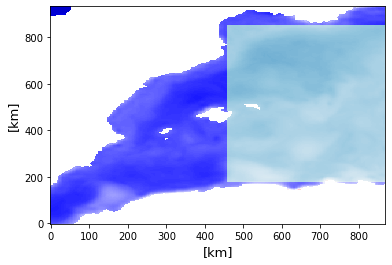

In [58]:
fig, ax = plt.subplots()
ax.pcolormesh(llc03w_H.isel(time=0).XC*1e-3, llc03w_H.isel(time=0).YC*1e-3,
              llc03w_H.isel(time=0), cmap='seismic', vmin=-1., vmax=1)
ax.pcolormesh(llc03w_H.isel(time=0).sel(YC=slice(1.8e5,8.5e5),XC=slice(4.6e5,None)).XC*1e-3,
              llc03w_H.isel(time=0).sel(YC=slice(1.8e5,8.5e5),XC=slice(4.6e5,None)).YC*1e-3,
              llc03w_H.isel(time=0).sel(YC=slice(1.8e5,8.5e5),XC=slice(4.6e5,None)), 
              cmap='RdBu_r', vmin=-1., vmax=1)
ax.set_xlabel("[km]", fontsize=13)
ax.set_ylabel("[km]", fontsize=13)

In [39]:
def _binned_agg(
    array: np.ndarray,
    indices: np.ndarray,
    num_bins: int,
    *,
    func,
    fill_value,
    dtype,
) -> np.ndarray:
    """NumPy helper function for aggregating over bins."""

    try:
        import numpy_groupies
    except ImportError:
        raise ImportError(
            "This function requires the `numpy_groupies` package to be installed. Please install it with pip or conda."
        )

    mask = np.logical_not(np.isnan(indices))
    int_indices = indices[mask].astype(int)
    shape = array.shape[: -indices.ndim] + (num_bins,)
    result = numpy_groupies.aggregate(
        int_indices,
        array[..., mask],
        func=func,
        size=num_bins,
        fill_value=fill_value,
        dtype=dtype,
        axis=-1,
    )
    return result


def _groupby_bins_agg(
    array: xr.DataArray,
    group: xr.DataArray,
    bins,
    func="sum",
    fill_value=0,
    dtype=None,
    **cut_kwargs,
) -> xr.DataArray:
    """Faster equivalent of Xarray's groupby_bins(...).sum()."""
    # https://github.com/pydata/xarray/issues/4473
    binned = pd.cut(np.ravel(group), bins, **cut_kwargs)
    new_dim_name = group.name + "_bins"
    indices = group.copy(data=binned.codes.reshape(group.shape))

    result = xr.apply_ufunc(
        _binned_agg,
        array,
        indices,
        input_core_dims=[indices.dims, indices.dims],
        output_core_dims=[[new_dim_name]],
        output_dtypes=[array.dtype],
        dask_gufunc_kwargs=dict(
            allow_rechunk=True,
            output_sizes={new_dim_name: binned.categories.size},
        ),
        kwargs={
            "num_bins": binned.categories.size,
            "func": func,
            "fill_value": fill_value,
            "dtype": dtype,
        },
        dask="parallelized",
    )
    result.coords[new_dim_name] = binned.categories
    return result


def isotropize(ps, fftdim, nfactor=4, **kwargs):
    """
    Isotropize a 2D power spectrum or cross spectrum
    by taking an azimuthal average.
    .. math::
        \text{iso}_{ps} = k_r N^{-1} \sum_{N} |\mathbb{F}(da')|^2
    where :math:`N` is the number of azimuthal bins.
    Parameters
    ----------
    ps : `xarray.DataArray`
        The power spectrum or cross spectrum to be isotropized.
    fftdim : list
        The fft dimensions overwhich the isotropization must be performed.
    nfactor : int, optional
        Ratio of number of bins to take the azimuthal averaging with the
        data size. Default is 4.
    """

    # compute radial wavenumber bins
    k = ps[fftdim[1]]
    l = ps[fftdim[0]]

    N = [k.size, l.size]
    nbins = int(min(N) / nfactor)
    freq_r = np.sqrt(k ** 2 + l ** 2).rename("freq_r")
    kr = _groupby_bins_agg(freq_r, freq_r, bins=nbins, func="mean")

    if "truncate" in kwargs:
        if truncate:
            if k.max() > l.max():
                kmax = l.max()
            else:
                kmax = k.max()
            kr = kr.where(kr <= kmax)
        else:
            msg = (
                "The flag `truncate` will be set to True by default in future version "
                + "in order to truncate the isotropic wavenumber larger than the "
                + "Nyquist wavenumber."
            )
            warnings.warn(msg, FutureWarning)

    iso_ps = (
        _groupby_bins_agg(ps, freq_r, bins=nbins, func="mean")
        .rename({"freq_r_bins": "freq_r"})
        .drop_vars("freq_r")
    )
    iso_ps.coords["freq_r"] = kr.data
    if "truncate" in kwargs:
        if truncate:
            return (iso_ps * iso_ps.freq_r).dropna("freq_r")
    else:
        return iso_ps * iso_ps.freq_r

In [59]:
Fenatlw_H = xrft.dft(xrft.dft(enatl03w_H.sel(YC=slice(1.7e5,8.5e5),XC=slice(4.3e5,None)).fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                     dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                    )
Fenatlw_H = Fenatlw_H.isel(freq_time=slice(len(Fenatlw_H.freq_time)//2,None)) * 2

Fenatls_H = xrft.dft(xrft.dft(enatl03s_H.sel(YC=slice(1.7e5,8.5e5),XC=slice(4.3e5,None)).fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                     dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                    )
Fenatls_H = Fenatls_H.isel(freq_time=slice(len(Fenatls_H.freq_time)//2,None)) * 2

Fenatls_H

<xarray.DataArray (freq_time: 732, freq_YC: 496, freq_XC: 274)>
dask.array<mul, shape=(732, 496, 274), dtype=complex128, chunksize=(732, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * freq_YC    (freq_YC) float64 -0.0003651 -0.0003636 ... 0.0003622 0.0003636
  * freq_XC    (freq_XC) float64 -0.0003488 -0.0003463 ... 0.0003437 0.0003463
  * freq_time  (freq_time) float64 0.0 1.897e-07 ... 0.0001385 0.0001387

In [60]:
tmp_path = f'{SCRATCH}/region03/eNATL60/'+f'SSH_omega-k-l_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fenatlw_H.to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

tmp_path = f'{SCRATCH}/region03/eNATL60/'+f'SSH_omega-k-l_aso.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fenatls_H.to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

gcs://meom-ige-scratch/roxyboy/region03/eNATL60/SSH_omega-k-l_fma.zarr
gcs://meom-ige-scratch/roxyboy/region03/eNATL60/SSH_omega-k-l_aso.zarr


In [40]:
Fenatlw_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region03/eNATL60/SSH_omega-k-l_fma.zarr")).spectra
isoFenatlw_H = isotropize(np.abs(Fenatlw_H.chunk({'freq_time':10}))**2, 
                          ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                         ).compute() 
Fenatls_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region03/eNATL60/SSH_omega-k-l_aso.zarr")).spectra
isoFenatls_H = isotropize(np.abs(Fenatls_H.chunk({'freq_time':10}))**2, 
                          ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                         ).compute() 
isoFenatlw_H

<xarray.DataArray (freq_time: 1068, freq_r: 143)>
array([[1.08745111e+25, 1.47875990e+25, 8.31418254e+24, ...,
        1.03986582e+21, 8.95363259e+20, 5.24015069e+20],
       [1.12494879e+26, 3.80717239e+25, 2.32192525e+25, ...,
        1.70950542e+22, 1.56636177e+22, 9.72624253e+21],
       [6.96695430e+25, 2.34400778e+25, 1.67994692e+25, ...,
        1.01143964e+22, 9.22886333e+21, 5.75009363e+21],
       ...,
       [2.65339702e+20, 7.22369308e+19, 2.61403044e+19, ...,
        3.39660164e+16, 2.59121962e+16, 3.13275962e+16],
       [1.78108154e+20, 3.19728801e+19, 1.16755252e+19, ...,
        1.51413496e+16, 1.49098669e+16, 1.93377798e+16],
       [6.31979549e+19, 1.75130078e+19, 8.56828171e+18, ...,
        1.08422634e+16, 7.90776343e+15, 5.02678272e+15]])
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.3e-07 2.601e-07 ... 0.0001386 0.0001388
  * freq_r     (freq_r) float64 2.395e-06 5.509e-06 ... 0.0004991 0.0005023

In [61]:
Fhycomw_H = xrft.dft(xrft.dft(hycom03w_H.sel(YC=slice(1.6e5,8.4e5),XC=slice(4.5e5,None)).fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                     dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                    )
Fhycomw_H = Fhycomw_H.isel(freq_time=slice(len(Fhycomw_H.freq_time)//2,None)) * 2

Fhycoms_H = xrft.dft(xrft.dft(hycom03s_H.sel(YC=slice(1.6e5,8.4e5),XC=slice(4.5e5,None)).fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                     dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                    )
Fhycoms_H = Fhycoms_H.isel(freq_time=slice(len(Fhycoms_H.freq_time)//2,None)) * 2

Fhycoms_H

<xarray.DataArray (freq_time: 1104, freq_YC: 397, freq_XC: 240)>
dask.array<mul, shape=(1104, 397, 240), dtype=complex128, chunksize=(1104, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * freq_YC    (freq_YC) float64 -0.0002912 -0.0002897 ... 0.0002897 0.0002912
  * freq_XC    (freq_XC) float64 -0.0002919 -0.0002895 ... 0.0002871 0.0002895
  * freq_time  (freq_time) float64 0.0 1.258e-07 ... 0.0001386 0.0001388

In [62]:
tmp_path = f'{SCRATCH}/region03/HYCOM50/'+f'SSH_omega-k-l_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fhycomw_H.to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

tmp_path = f'{SCRATCH}/region03/HYCOM50/'+f'SSH_omega-k-l_aso.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fhycoms_H.to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

gcs://meom-ige-scratch/roxyboy/region03/HYCOM50/SSH_omega-k-l_fma.zarr
gcs://meom-ige-scratch/roxyboy/region03/HYCOM50/SSH_omega-k-l_aso.zarr


In [43]:
Fhycomw_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region03/HYCOM50/SSH_omega-k-l_fma.zarr")).spectra
isoFhycomw_H = isotropize(np.abs(Fhycomw_H.chunk({'freq_time':10}))**2, 
                          ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                         ).compute() 
Fhycoms_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region03/HYCOM50/SSH_omega-k-l_aso.zarr")).spectra
isoFhycoms_H = isotropize(np.abs(Fhycoms_H.chunk({'freq_time':10}))**2, 
                          ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                         ).compute() 
isoFhycomw_H

<xarray.DataArray (freq_time: 1080, freq_r: 125)>
array([[2.30725711e+24, 9.37520289e+24, 8.29184451e+24, ...,
        1.15338008e+20, 1.06680506e+20, 8.05691434e+19],
       [7.53933248e+24, 1.57279747e+25, 1.39772420e+25, ...,
        7.26878439e+20, 6.78995729e+20, 5.39846049e+20],
       [1.38071059e+25, 1.15945787e+25, 1.56543950e+25, ...,
        1.97755742e+21, 1.80981835e+21, 1.62547859e+21],
       ...,
       [1.04137753e+19, 6.46474370e+18, 2.79582405e+18, ...,
        5.19958727e+15, 3.81389816e+15, 4.04181316e+15],
       [3.47184363e+19, 1.19971242e+19, 7.63226298e+18, ...,
        1.05244205e+16, 8.96272033e+15, 3.89887136e+15],
       [6.28840182e+19, 2.78862976e+19, 1.76838330e+19, ...,
        1.23691808e+16, 1.44869756e+16, 4.63763938e+15]])
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.286e-07 ... 0.0001386 0.0001388
  * freq_r     (freq_r) float64 2.136e-06 5.093e-06 ... 0.0004071 0.0004102

In [63]:
Fllcw_H = xrft.dft(xrft.dft(llc03w_H.sel(YC=slice(1.8e5,8.5e5),XC=slice(4.6e5,None)).fillna(0.), 
                            dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                           ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                   dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                  )
Fllcw_H = Fllcw_H.isel(freq_time=slice(len(Fllcw_H.freq_time)//2,None)) * 2

Fllcs_H = xrft.dft(xrft.dft(llc03s_H.sel(YC=slice(1.8e5,8.5e5),XC=slice(4.6e5,None)).fillna(0.), 
                            dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                           ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                   dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                  )
Fllcs_H = Fllcs_H.isel(freq_time=slice(len(Fllcs_H.freq_time)//2,None)) * 2

Fllcs_H

<xarray.DataArray (freq_time: 1104, freq_YC: 203, freq_XC: 115)>
dask.array<mul, shape=(1104, 203, 115), dtype=complex128, chunksize=(1104, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * freq_YC    (freq_YC) float64 -0.0001506 -0.0001491 ... 0.0001491 0.0001506
  * freq_XC    (freq_XC) float64 -0.0001389 -0.0001365 ... 0.0001365 0.0001389
  * freq_time  (freq_time) float64 0.0 1.258e-07 ... 0.0001386 0.0001388

In [65]:
tmp_path = f'{SCRATCH}/region03/LLC4320/'+f'SSH_omega-k-l_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
Fllcw_H.to_dataset(name='spectra').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region03/LLC4320/SSH_omega-k-l_fma.zarr


In [67]:
tmp_path = f'{SCRATCH}/region03/LLC4320/'+f'SSH_omega-k-l_aso.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
Fllcs_H.to_dataset(name='spectra').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region03/LLC4320/SSH_omega-k-l_aso.zarr


In [68]:
Fllcw_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region03/LLC4320/SSH_omega-k-l_fma.zarr")).spectra
isoFllcw_H = isotropize(np.abs(Fllcw_H.chunk({'freq_time':10}))**2, 
                        ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                       ).compute() 
Fllcs_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region03/LLC4320/SSH_omega-k-l_aso.zarr")).spectra
isoFllcs_H = isotropize(np.abs(Fllcs_H.chunk({'freq_time':10}))**2, 
                        ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                       ).compute() 
isoFllcw_H

<xarray.DataArray (freq_time: 1080, freq_r: 28)>
array([[9.81208032e+23, 1.38017967e+24, 2.05442482e+23, ...,
        3.16559608e+20, 2.06190728e+20, 9.58883611e+19],
       [1.71355017e+24, 3.06559997e+24, 3.61917554e+23, ...,
        5.77952246e+20, 3.75763917e+20, 1.70449588e+20],
       [9.65219104e+23, 3.48103557e+24, 4.57911785e+23, ...,
        3.38452349e+20, 2.19386052e+20, 9.23479421e+19],
       ...,
       [2.03402149e+16, 1.44974857e+14, 3.20531410e+13, ...,
        5.93532834e+14, 4.89649224e+14, 3.17290526e+14],
       [2.22716569e+16, 1.37315754e+14, 3.62931128e+13, ...,
        6.11718957e+14, 6.12976585e+14, 3.90520815e+14],
       [2.14099474e+16, 1.57593248e+14, 6.07526138e+13, ...,
        6.00059064e+14, 6.13796340e+14, 4.79519578e+14]])
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.286e-07 ... 0.0001386 0.0001388
  * freq_r     (freq_r) float64 4.692e-06 1.124e-05 ... 0.0001935 0.0002004

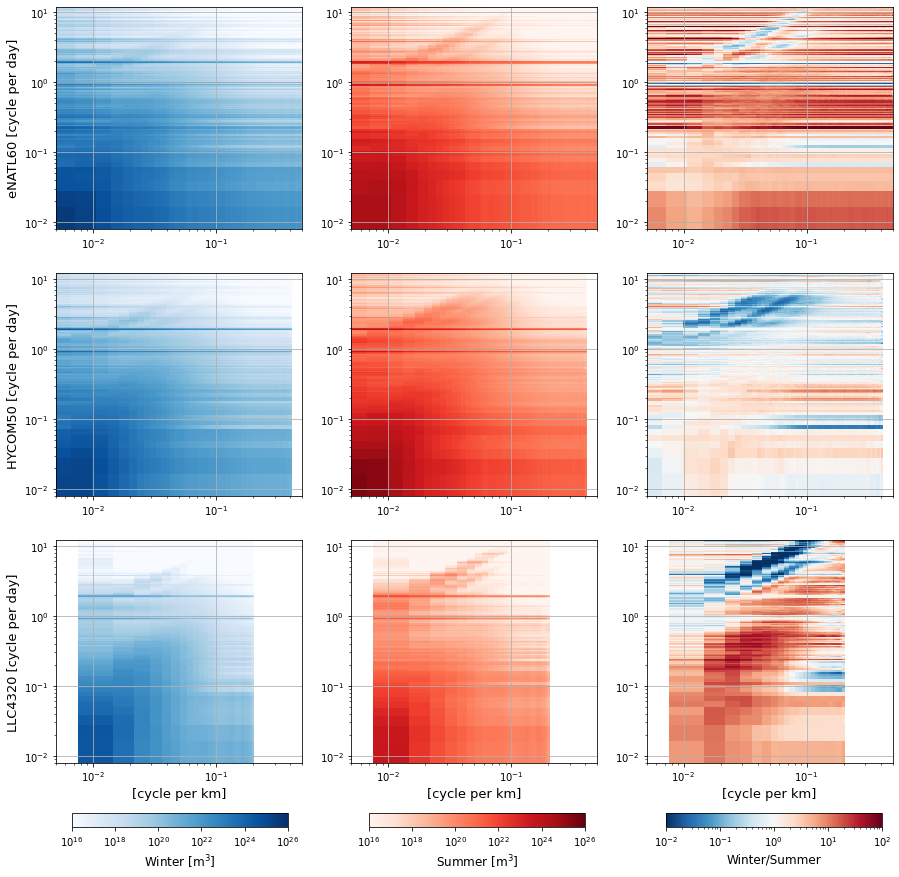

In [69]:
fig, axes = plt.subplots(figsize=(15,15), nrows=3, ncols=3)
# fig.set_tight_layout(True)
ax00 = axes[0,0]
ax01 = axes[0,1]
ax02 = axes[0,2]
ax10 = axes[1,0]
ax11 = axes[1,1]
ax12 = axes[1,2]
# ax20 = axes[2,0]
# ax21 = axes[2,1]
# ax22 = axes[2,2]
ax30 = axes[2,0]
ax31 = axes[2,1]
ax32 = axes[2,2]


im0 = ax00.pcolormesh(isoFenatlw_H.freq_r.isel(freq_r=slice(1,None))*1e3,
                      isoFenatlw_H.freq_time.isel(freq_time=slice(1,None))*86400,
                      isoFenatlw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
                      cmap='Blues', norm=clr.LogNorm(vmin=1e16, vmax=1e26), 
                      rasterized=True)
ax10.pcolormesh(isoFhycomw_H.freq_r.isel(freq_r=slice(1,None))*1e3,
                isoFhycomw_H.freq_time.isel(freq_time=slice(1,None))*86400,
                isoFhycomw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
                cmap='Blues', norm=clr.LogNorm(vmin=1e16, vmax=1e26), 
                rasterized=True)
# ax20.pcolormesh(isoFgigatlw_H.freq_r.isel(freq_r=slice(1,None))*1e3,
#                 isoFgigatlw_H.freq_time.isel(freq_time=slice(1,None))*86400,
#                 isoFgigatlw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
#                 cmap='Blues', norm=clr.LogNorm(vmin=1e16, vmax=1e26), 
#                 rasterized=True)
ax30.pcolormesh(isoFllcw_H.freq_r.isel(freq_r=slice(1,None))*1e3,
                isoFllcw_H.freq_time.isel(freq_time=slice(1,None))*86400,
                isoFllcw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
                cmap='Blues', norm=clr.LogNorm(vmin=1e16, vmax=1e26),
                rasterized=True)

im1 = ax01.pcolormesh(isoFenatls_H.freq_r.isel(freq_r=slice(1,None))*1e3, 
                      isoFenatls_H.freq_time.isel(freq_time=slice(1,None))*86400, 
                      isoFenatls_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
                      cmap='Reds', norm=clr.LogNorm(vmin=1e16, vmax=1e26), 
                      rasterized=True)
ax11.pcolormesh(isoFhycoms_H.freq_r.isel(freq_r=slice(1,None))*1e3,
                isoFhycoms_H.freq_time.isel(freq_time=slice(1,None))*86400,
                isoFhycoms_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
                cmap='Reds', norm=clr.LogNorm(vmin=1e16, vmax=1e26), 
                rasterized=True)
# ax21.pcolormesh(isoFgigatls_H.freq_r.isel(freq_r=slice(1,None))*1e3,
#                 isoFgigatls_H.freq_time.isel(freq_time=slice(1,None))*86400,
#                 isoFgigatls_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
#                 cmap='Reds', norm=clr.LogNorm(vmin=1e16, vmax=1e26), 
#                 rasterized=True)
ax31.pcolormesh(isoFllcs_H.freq_r.isel(freq_r=slice(1,None))*1e3, 
                isoFllcs_H.freq_time.isel(freq_time=slice(1,None))*86400, 
                isoFllcs_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
                cmap='Reds', norm=clr.LogNorm(vmin=1e16, vmax=1e26),
                rasterized=True)

im2 = ax02.pcolormesh(isoFenatlw_H.freq_r.isel(freq_r=slice(1,None))*1e3, 
                      isoFenatlw_H.freq_time.isel(freq_time=slice(1,None))*86400, 
                      (isoFenatlw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None))
                       / isoFenatls_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)
                                          ).interp(freq_time=isoFenatlw_H.freq_time, 
                                                   kwargs={'fill_value':'extrapolate'})
                      ), 
                      cmap='RdBu_r', norm=clr.LogNorm(vmin=1e-2, vmax=1e2), 
                      rasterized=True)
ax12.pcolormesh(isoFhycomw_H.freq_r.isel(freq_r=slice(1,None))*1e3,
                isoFhycomw_H.freq_time.isel(freq_time=slice(1,None))*86400,
                (isoFhycomw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None))
                 / isoFhycoms_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)
                                    ).interp(freq_time=isoFhycomw_H.freq_time.isel(freq_time=slice(1,None)))
                ), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=1e-2, vmax=1e2), 
                rasterized=True)
# ax22.pcolormesh(isoFgigatlw_H.freq_r.isel(freq_r=slice(1,None))*1e3,
#                 isoFgigatlw_H.freq_time.isel(freq_time=slice(1,None))*86400,
#                 (isoFgigatlw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None))
#                  / isoFgigatls_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)
#                                      ).interp(freq_time=isoFgigatlw_H.freq_time.isel(freq_time=slice(1,None)))
#                 ), 
#                 cmap='RdBu_r', norm=clr.LogNorm(vmin=1e-2, vmax=1e2), 
#                 rasterized=True)
ax32.pcolormesh(isoFllcw_H.freq_r.isel(freq_r=slice(1,None))*1e3,
                isoFllcw_H.freq_time.isel(freq_time=slice(1,None))*86400,
                (isoFllcw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None))
                 / isoFllcs_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)
                                  ).interp(freq_time=isoFllcw_H.freq_time.isel(freq_time=slice(1,None)))
                ), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=1e-2, vmax=1e2), 
                rasterized=True)


ax00.set_xlim([5e-3,5e-1])
ax01.set_xlim([5e-3,5e-1])
ax02.set_xlim([5e-3,5e-1])
ax10.set_xlim([5e-3,5e-1])
ax11.set_xlim([5e-3,5e-1])
ax12.set_xlim([5e-3,5e-1])
# ax20.set_xlim([5e-3,5e-1])
# ax21.set_xlim([5e-3,5e-1])
# ax22.set_xlim([5e-3,5e-1])
ax30.set_xlim([5e-3,5e-1])
ax31.set_xlim([5e-3,5e-1])
ax32.set_xlim([5e-3,5e-1])
ax00.set_ylim([8e-3,None])
ax01.set_ylim([8e-3,None])
ax02.set_ylim([8e-3,None])
ax10.set_ylim([8e-3,None])
ax11.set_ylim([8e-3,None])
ax12.set_ylim([8e-3,None])
# ax20.set_ylim([8e-3,None])
# ax21.set_ylim([8e-3,None])
# ax22.set_ylim([8e-3,None])
ax30.set_ylim([8e-3,None])
ax31.set_ylim([8e-3,None])
ax32.set_ylim([8e-3,None])

ax00.set_xscale('log')
ax00.set_yscale('log')
ax01.set_xscale('log')
ax01.set_yscale('log')
ax02.set_xscale('log')
ax02.set_yscale('log')
ax10.set_xscale('log')
ax10.set_yscale('log')
ax11.set_xscale('log')
ax11.set_yscale('log')
ax12.set_xscale('log')
ax12.set_yscale('log')
# ax20.set_xscale('log')
# ax20.set_yscale('log')
# ax21.set_xscale('log')
# ax21.set_yscale('log')
# ax22.set_xscale('log')
# ax22.set_yscale('log')
ax30.set_xscale('log')
ax30.set_yscale('log')
ax31.set_xscale('log')
ax31.set_yscale('log')
ax32.set_xscale('log')
ax32.set_yscale('log')

ax30.set_xlabel(r"[cycle per km]", fontsize=13)
ax31.set_xlabel(r"[cycle per km]", fontsize=13)
ax32.set_xlabel(r"[cycle per km]", fontsize=13)
ax00.set_ylabel(r"eNATL60 [cycle per day]", fontsize=13)
ax10.set_ylabel(r"HYCOM50 [cycle per day]", fontsize=13)
# ax20.set_ylabel(r"GIGATL [cycle per day]", fontsize=13)
ax30.set_ylabel(r"LLC4320 [cycle per day]", fontsize=13)

ax00.grid(True)
ax01.grid(True)
ax02.grid(True)
ax10.grid(True)
ax11.grid(True)
ax12.grid(True)
# ax20.grid(True)
# ax21.grid(True)
# ax22.grid(True)
ax30.grid(True)
ax31.grid(True)
ax32.grid(True)

fig.subplots_adjust(bottom=.18, hspace=.2) 
cbax0 = fig.add_axes([0.14, 0.12, 0.2, 0.013])
cbar0 = fig.colorbar(im0, orientation='horizontal', cax=cbax0)
cbar0.set_label(r"Winter [m$^3$]", fontsize=12)

cbax1 = fig.add_axes([0.415, 0.12, 0.2, 0.013])
cbar1 = fig.colorbar(im1, orientation='horizontal', cax=cbax1)
cbar1.set_label(r"Summer [m$^3$]", fontsize=12)

cbax2 = fig.add_axes([0.69, 0.12, 0.2, 0.013])
cbar2 = fig.colorbar(im2, orientation='horizontal', cax=cbax2)
cbar2.set_label(r"Winter/Summer", fontsize=12)

plt.savefig('/home/jovyan/Figures/omega-k-spectra_surfH_03.pdf')

In [ ]:
client.close()